In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

def generate_dollar_bars(trades_df, target_hour=1):
    """生成近似目标小时级的Dollar Bar"""
    # 计算小时级平均成交额作为阈值
    hourly_volume = trades_df.resample(f'{target_hour}H', on='trade_time')['dollar_amount'].sum()
    dollar_threshold = hourly_volume.mean()  # 阈值=目标小时级平均成交额
    
    # 生成Bar
    trades_df['cum_dollar'] = trades_df['dollar_amount'].cumsum()
    trades_df['bar_id'] = (trades_df['cum_dollar'] // dollar_threshold).astype(int)
    
    # 过滤不完整的最后一个Bar
    last_valid_id = trades_df['bar_id'].max() - 1
    trades_df = trades_df[trades_df['bar_id'] <= last_valid_id]
    
    # 提取每个Bar的时间区间和基础统计量
    bar_info = trades_df.groupby('bar_id').agg(
        start_time=('trade_time', 'min'),
        end_time=('trade_time', 'max'),
        total_dollar=('dollar_amount', 'sum'),
        price_open=('price', 'first'),
        price_close=('price', 'last'),
        price_high=('price', 'max'),
        price_low=('price', 'min'),
        trade_count=('price', 'count')
    ).reset_index()
    
    # 计算Bar的未来收益（预测目标：下一个Bar的涨跌幅）
    bar_info['future_return'] = (bar_info['price_close'].shift(-1) - bar_info['price_close']) / bar_info['price_close'] * 100
    
    return trades_df, bar_info, dollar_threshold

def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 核心改进：逐笔计算bar_id，确保连续递增
    cumulative = 0.0  # 累积成交额
    bar_id = 0        # 当前bar_id
    bar_ids = []      # 存储每个交易的bar_id
    cnt_list = []
    bar_trade_counts={}
    
    for qty in df['quote_qty']:
        cumulative += qty
        bar_trade_counts[bar_id] = bar_trade_counts.get(bar_id, 0) + 1
        # 当累积成交额达到阈值时，当前交易仍属于当前bar_id，随后bar_id递增并重置累积
        if cumulative >= dollar_threshold:
            bar_ids.append(bar_id)
            # 重置累积（保留超额部分，用于下一个bar的计算）
            cumulative -= dollar_threshold
            bar_id += 1
            # bar_ids.append(bar_id)
        else:
            bar_ids.append(bar_id)
    
    df['bar_id'] = bar_ids
    df['trades'] = df['bar_id'].map(bar_trade_counts)  # 关键修复：通过map对齐

    df = df.reset_index().rename(columns={'index': 'original_index'})
    
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
        'trades': 'first',
        'original_index': ['first', 'last']
    }
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume',
        'trades','start_trade_idx', 
        'end_trade_idx'
    ]
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    g['end_trade_idx'] = g['end_trade_idx'] + 1
    return g
 


def _add_bar_lags_and_rollings(
    Xb: pd.DataFrame,
    add_lags: int = 2,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
) -> pd.DataFrame:
    X = Xb.copy().sort_index()

    feature_cols = list(X.columns)

    # lags
    for k in range(1, add_lags + 1):
        for col in feature_cols:
            X[f'{col}_lag{k}'] = X[col].shift(k)

    # rollings
    if rolling_windows:
        stats = rolling_stats or ['mean', 'std', 'sum']
        for w in rolling_windows:
            roll = X[feature_cols].rolling(window=w, min_periods=w)
            for stat in stats:
                if stat == 'mean':
                    tmp = roll.mean()
                elif stat == 'std':
                    tmp = roll.std()
                elif stat == 'sum':
                    tmp = roll.sum()
                elif stat == 'min':
                    tmp = roll.min()
                elif stat == 'max':
                    tmp = roll.max()
                else:
                    continue
                tmp.columns = [f'{col}_roll{w}_{stat}' for col in X[feature_cols].columns]
                X = X.join(tmp)

    return X


 


def _time_splits_purged(
    idx: pd.DatetimeIndex,
    n_splits: int = 5,
    embargo: str = '0H',
) -> List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]]:
    """
    生成时间连续的折，返回 (train_index, test_index) 对列表。
    训练集对测试集边界施加 Embargo，避免信息泄露。
    """
    times = pd.Series(index=idx.unique().sort_values(), data=np.arange(len(idx.unique())))
    n = len(times)
    if n_splits < 2 or n < n_splits:
        raise ValueError('样本过少，无法进行时间序列CV')

    fold_sizes = [n // n_splits] * n_splits
    for i in range(n % n_splits):
        fold_sizes[i] += 1

    # 计算各折在时间索引上的切片范围
    boundaries = []
    start = 0
    for sz in fold_sizes:
        end = start + sz
        boundaries.append((start, end))
        start = end

    embargo_td = pd.Timedelta(embargo)
    out: List[Tuple[pd.DatetimeIndex, pd.DatetimeIndex]] = []
    for (s, e) in boundaries:
        test_times = times.index[s:e]
        test_mask = idx.isin(test_times)

        test_start = test_times.min()
        test_end = test_times.max()

        left_block  = (idx >= (test_start - embargo_td)) & (idx <  test_start)
        right_block = (idx >  test_end)                  & (idx <= (test_end + embargo_td))
        exclude = left_block | right_block | test_mask   # 再加上测试集本身
        train_idx = idx[~exclude]
        test_idx  = idx[test_mask]
        if len(train_idx) == 0 or len(test_idx) == 0:
            continue
        out.append((train_idx, test_idx))
    return out



In [3]:
# def purged_cv_evaluate(
#     X: pd.DataFrame,
#     y: pd.Series,
#     n_splits: int = 5,
#     embargo: str = '1H',
#     model_type: str = 'ridge',
#     random_state: int = 42,
#     fee_rate: float = 1e-4,
#     annualize: bool = True,
#     period_seconds: Optional[float] = None,
#     seconds_per_year: float = 365.0 * 24.0 * 3600.0,
# ) -> Dict:
#     """
#     使用 Purged 时间序列 CV 进行回归评估，返回按折与汇总的指标。
#     指标：Pearson IC、Spearman IC、RMSE、方向准确率。
#     """
#     assert X.index.equals(y.index)

#     # 选择模型
#     if model_type == 'rf':
#         base_model = RandomForestRegressor(
#             n_estimators=300, max_depth=8, random_state=random_state, n_jobs=-1
#         )
#         use_scaler = False
#     else:
#         base_model = Ridge(alpha=1.0, random_state=random_state)
#         use_scaler = True

#     splits = _time_splits_purged(X.index, n_splits=n_splits, embargo=embargo)
#     by_fold = []
#     preds_all = pd.Series(index=X.index, dtype=float)

#     for fold_id, (tr_idx, te_idx) in enumerate(splits):
#         Xtr, ytr = X.loc[tr_idx], y.loc[tr_idx]
#         Xte, yte = X.loc[te_idx], y.loc[te_idx]

#         Xtr.drop(columns=['interval_start', 'interval_end'], inplace=True)
#         Xte.drop(columns=['interval_start', 'interval_end'], inplace=True)
#         ytr.drop(columns=['end_time'], inplace=True)
#         yte.drop(columns=['end_time'], inplace=True)
#         if use_scaler:
#             scaler = StandardScaler()
#             Xtr_scaled = pd.DataFrame(
#                 scaler.fit_transform(Xtr.values), index=Xtr.index, columns=Xtr.columns
#             )
#             Xte_scaled = pd.DataFrame(
#                 scaler.transform(Xte.values), index=Xte.index, columns=Xte.columns
#             )
#         else:
#             Xtr_scaled, Xte_scaled = Xtr, Xte

#         model = base_model
#         model.fit(Xtr_scaled, ytr)
#         yhat = pd.Series(model.predict(Xte_scaled), index=te_idx)
#         preds_all.loc[te_idx] = yhat

#         # 预测与误差指标
#         pearson_ic = yhat.corr(yte)
#         spearman_ic = yhat.corr(yte, method='spearman')
#         rmse = mean_squared_error(yte, yhat) ** 0.5
#         dir_acc = (np.sign(yhat) == np.sign(yte)).mean()

#         # 简单交易指标（方向持仓，含手续费）
#         pos = np.sign(yhat).fillna(0.0)
#         ret_gross = (pos * yte).astype(float)
#         turnover = pos.diff().abs().fillna(np.abs(pos.iloc[0]))
#         ret_net = ret_gross - fee_rate * turnover
#         sharpe_net = float(ret_net.mean() / ret_net.std()) if ret_net.std() > 0 else np.nan
#         if annualize and pd.notna(sharpe_net):
#             ps = float(period_seconds) if (period_seconds is not None and period_seconds > 0) else np.nan
#             if np.isfinite(ps) and ps > 0:
#                 ann_factor = np.sqrt(seconds_per_year / ps)
#                 sharpe_net_ann = float(sharpe_net * ann_factor)
#             else:
#                 sharpe_net_ann = np.nan
#         else:
#             sharpe_net_ann = np.nan

#         plot_predictions_vs_truth(yhat, yte, save_path = '/Users/aming/project/python/crypto-trade/strategy/fusion/pic/')

#         by_fold.append({
#             'fold': fold_id,
#             'pearson_ic': float(pearson_ic),
#             'spearman_ic': float(spearman_ic),
#             'rmse': float(rmse),
#             'dir_acc': float(dir_acc),
#             'ret_gross_mean': float(ret_gross.mean()),
#             'ret_net_mean': float(ret_net.mean()),
#             'ret_net_std': float(ret_net.std()) if ret_net.std() > 0 else np.nan,
#             'sharpe_net': sharpe_net,
#             'sharpe_net_ann': sharpe_net_ann,
#             'fee_rate': float(fee_rate),
#             'n_train': int(len(Xtr)),
#             'n_test': int(len(Xte)),
#         })

#     # 汇总
#     df_folds = pd.DataFrame(by_fold)
#     summary = {
#         'pearson_ic_mean': float(df_folds['pearson_ic'].mean()) if not df_folds.empty else np.nan,
#         'spearman_ic_mean': float(df_folds['spearman_ic'].mean()) if not df_folds.empty else np.nan,
#         'rmse_mean': float(df_folds['rmse'].mean()) if not df_folds.empty else np.nan,
#         'dir_acc_mean': float(df_folds['dir_acc'].mean()) if not df_folds.empty else np.nan,
#         'ret_gross_mean_mean': float(df_folds['ret_gross_mean'].mean()) if 'ret_gross_mean' in df_folds else np.nan,
#         'ret_net_mean_mean': float(df_folds['ret_net_mean'].mean()) if 'ret_net_mean' in df_folds else np.nan,
#         'sharpe_net_mean': float(df_folds['sharpe_net'].mean()) if 'sharpe_net' in df_folds else np.nan,
#         'sharpe_net_ann_mean': float(df_folds['sharpe_net_ann'].mean()) if 'sharpe_net_ann' in df_folds else np.nan,
#         'n_splits_effective': int(len(df_folds)),
#     }
#     return {
#         'by_fold': by_fold,
#         'summary': summary,
#         'predictions': preds_all,
#     }


# def make_barlevel_dataset(
#     trades: pd.DataFrame,
#     dollar_threshold: float,
#     horizon_bars: int = 1,
#     add_lags: int = 2,
#     rolling_windows: Optional[List[int]] = None,
#     rolling_stats: Optional[List[str]] = None,
# ) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.DataFrame]:
#     """
#     逐笔 -> Dollar Bars -> Bar特征 -> N-bar 标签（不做小时对齐）。
#     返回：X_bar, y_bar, bars, bar_features
#     """
#     # 1) 事件Bar
#     bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
#     if bars.empty:
#         return pd.DataFrame(), pd.Series(dtype=float), bars, pd.DataFrame()

#     # 2) Bar级特征（逐笔交易侧）
#     bar_feat = []
#     # bar_feat = aggregate_trade_features_on_bars(trades, bars)

#     # 3) 标签：未来 N 根 bar 的对数收益
#     close = bar_feat['close'] if 'close' in bar_feat.columns else bars.set_index('bar_id')['close']
#     y_bar = np.log(close.shift(-horizon_bars) / close)

#     # 4) 特征工程：去掉时间列，仅保留数值特征
#     keep_cols = [c for c in bar_feat.columns if c not in ['start_time', 'end_time']]
#     X_bar = bar_feat[keep_cols]
#     X_bar = _add_bar_lags_and_rollings(
#         X_bar,
#         add_lags=add_lags,
#         rolling_windows=rolling_windows,
#         rolling_stats=rolling_stats,
#     )

#     # 5) 对齐与去NaN
#     X_bar = X_bar.dropna()
#     y_bar = y_bar.loc[X_bar.index]

#     return X_bar, y_bar, bars, bar_feat




In [2]:
class TradesContext:
    def __init__(self, t_ns: np.ndarray, trades: pd.DataFrame, bars_df: pd.DataFrame, price: np.ndarray, qty: np.ndarray, quote: np.ndarray, sign: np.ndarray, order_type: np.ndarray):
        self.t_ns = t_ns  # int64 ns 时间戳（已排序）
        self.trades = trades
        self.bars_df = bars_df

        self.price = price.astype(np.float64)
        self.qty = qty.astype(np.float64)
        self.quote = quote.astype(np.float64)
        self.sign = sign.astype(np.float64)
        self.order_type = order_type
    

        # 衍生量
        self.logp = np.log(self.price)
        self.ret = np.diff(self.logp)
        self.ret2 = np.r_[0.0, self.ret ** 2]
        # |r_t||r_{t-1}| 对齐成与 price 同长（首位补0）
        abs_r = np.abs(self.ret)
        bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]  # 与 price 对齐

        # 前缀和（与 price 同长）
        self.csum_qty = np.cumsum(self.qty)
        self.csum_quote = np.cumsum(self.quote)
        self.csum_signed_qty = np.cumsum(self.sign * self.qty)
        self.csum_signed_quote = np.cumsum(self.sign * self.quote)
        self.csum_pxqty = np.cumsum(self.price * self.qty)
        self.csum_ret2 = np.cumsum(self.ret2)
        self.csum_bpv = np.cumsum(bp_core)

    def locate(self, start_ts: pd.Timestamp, end_ts: pd.Timestamp) -> Tuple[int, int]:
        s = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(start_ts, 'ns'))), side='left')
        e = np.searchsorted(self.t_ns, int(np.int64(np.datetime64(end_ts, 'ns'))), side='left')
        return s, e


def _build_trades_context(trades: pd.DataFrame, bars: pd.DataFrame) -> TradesContext:
    df = trades
    bars_df = bars
    t = _ensure_datetime(df['time']).values.astype('datetime64[ns]').astype('int64')
    # t = df['time']
    order = np.argsort(t)
    t_ns = t[order]
    price = df['price'].to_numpy(dtype=float)[order]
    qty = df['qty'].to_numpy(dtype=float)[order]
    quote = (df['quote_qty'] if 'quote_qty' in df.columns else df['price'] * df['qty']).to_numpy(dtype=float)[order]
    sign = np.where(df['is_buyer_maker'].to_numpy()[order], -1.0, 1.0)
    order_type = df['order_type']
    return TradesContext(t_ns, df, bars_df, price, qty, quote, sign, order_type)


def _sum_range(prefix: np.ndarray, s: int, e: int) -> float:
    if e <= s:
        return 0.0
    return float(prefix[e - 1] - (prefix[s - 1] if s > 0 else 0.0))

def _default_features_config() -> Dict[str, bool]:
    return {
        'base': False,                   # 基础汇总/VWAP/强度/买量占比
        'order_flow': False,             # GOF/签名不平衡
        'price_impact': True,           # Kyle/Amihud/Hasbrouck/半衰期/占比
        'volatility_noise': True,       # RV/BPV/Jump/微动量/均值回复/高低幅比
        'arrival_stats': False,          # 到达间隔统计
        'run_markov': True,             # run-length/Markov/翻转率
        'rolling_ofi': False,            # 滚动OFI
        'hawkes': False,                 # 聚簇（Hawkes近似）
        'path_shape': True,             # 协动相关/VWAP偏离
        'tail': False,                   # 大单尾部比例
        'bar_features': False,  
        'big_order': False,  
        'tail_directional' : True,
        'smart_money' : False
    }

def _fast_price_impact_metrics(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    """
    价格冲击与流动性代理（fast）：
    - Kyle λ：Δlogp ~ signed_dollar（协方差/方差比）
    - Amihud λ：mean(|Δlogp| / dollar)
    - Hasbrouck（简化）：Δlogp ~ sign(Δlogp)*sqrt(dollar)
    - impact_half_life：Δlogp 的 lag-1 自相关半衰期
    - impact_perm/transient_share：|p_end - p_start| / ∑|Δp|
    返回空dict表示样本不足。
    """
    if e - s < 3:
        return {}
    r = np.diff(ctx.logp[s:e])                # 长度 K-1
    sdollar = ctx.sign[s:e] * ctx.quote[s:e]  # 长度 K
    x = sdollar[1:]                           # 与 r 对齐
    y = r
    varx = float(np.var(x))
    kyle = float(np.cov(x, y, ddof=1)[0, 1] / varx) if varx > 0 else np.nan

    amihud = float((np.abs(r) / (ctx.quote[s+1:e])).mean()) if np.all(ctx.quote[s+1:e] > 0) else np.nan

    xh = np.sign(r) * np.sqrt(ctx.quote[s+1:e])
    varxh = float(np.var(xh))
    hasb = float(np.cov(xh, r, ddof=1)[0, 1] / varxh) if varxh > 0 and len(r) > 1 else np.nan

    # 半衰期
    r0 = r[:-1] - np.mean(r[:-1])
    r1 = r[1:] - np.mean(r[1:])
    denom = np.sqrt(np.sum(r0**2) * np.sum(r1**2))
    if denom > 0:
        rho = float(np.sum(r0 * r1) / denom)
        t_half = float(np.log(2.0) / (-np.log(rho))) if (0 < rho < 1) else np.nan
    else:
        t_half = np.nan

    # 冲击占比
    dp = np.diff(ctx.price[s:e])
    denom2 = float(np.sum(np.abs(dp)))
    if denom2 > 0:
        perm = float(np.abs(ctx.price[e-1] - ctx.price[s]) / denom2)
        perm = float(np.clip(perm, 0.0, 1.0))
        trans = float(1.0 - perm)
    else:
        perm = np.nan
        trans = np.nan

    return {
        'kyle_lambda': kyle,
        'amihud_lambda': amihud,
        'hasbrouck_lambda': hasb,
        'impact_half_life': t_half,
        'impact_perm_share': perm,
        'impact_transient_share': trans,
    }

def _compute_interval_trade_features_fast(
    ctx: TradesContext,
    start_ts: pd.Timestamp,
    end_ts: pd.Timestamp,
    features_config: Optional[Dict[str, bool]] = None,
    tail_q: float = 0.9,
    bars: pd.DataFrame = None,
    bar_window_start_idx: int = None,
    bar_window_end_idx: int = None # 这里是下一个bar的idx
) -> Dict[str, float]:
    s_e_record =[]
    # origin_s, origin_e = ctx.locate(start_ts, end_ts)
    s, e = bars.loc[bar_window_start_idx, 'start_trade_idx'], bars.loc[bar_window_end_idx, 'end_trade_idx'] + 1
    if e - s <= 1:
        return {}
    s_e_record.append({
        's' : s,
        'e' : e,
        # 'origin_s' : origin_s,
        # 'origin_e' : origin_e,
        's_start_time': ctx.trades.loc[s, 'time'],
        'e_end_time': ctx.trades.loc[e, 'time'],
        'bar_window_start_idx': bar_window_start_idx, 
        'bar_window_end_idx': bar_window_end_idx,
        'bars_start_time': bars.loc[bar_window_start_idx, 'start_time'],
        'bars_time_end': bars.loc[bar_window_end_idx, 'end_time'],
        'bars_id_start': bars.loc[bar_window_start_idx, 'bar_id'],
        'bars_id_end': bars.loc[bar_window_end_idx, 'bar_id'],
    })
    # print('s_e_record: ',  s_e_record)
    cfg = _default_features_config()
    if features_config:
        cfg.update(features_config)

    rollling_window = round(0.1 * (e - s))
    # 基础聚合
    sum_qty = _sum_range(ctx.csum_qty, s, e)
    sum_quote = _sum_range(ctx.csum_quote, s, e)
    sum_signed_qty = _sum_range(ctx.csum_signed_qty, s, e)
    sum_signed_quote = _sum_range(ctx.csum_signed_quote, s, e)
    sum_pxqty = _sum_range(ctx.csum_pxqty, s, e)

    vwap = sum_pxqty / sum_qty if sum_qty > 0 else np.nan
    p_last = ctx.price[e - 1]
    duration = max(1.0, (end_ts - start_ts).total_seconds())
    intensity = (e - s) / duration

    # RV/BPV/Jump（ret2、bpv 与 price 对齐）
    rv = _sum_range(ctx.csum_ret2, s, e)
    bpv = _sum_range(ctx.csum_bpv, s, e)
    jump = max(rv - bpv, 0.0) if (np.isfinite(rv) and np.isfinite(bpv)) else np.nan

    # Garman OF (count/volume)
    n = float(e - s)
    # count 口径用 sign 的平均（与逐笔实现等价）
    gof_by_count = float(np.mean(np.sign(ctx.sign[s:e]))) if n > 0 else np.nan
    gof_by_volume = (sum_signed_qty / sum_qty) if sum_qty > 0 else np.nan

    # VWAP偏离（带符号）
    dev = (p_last - vwap) / vwap if vwap != 0 and np.isfinite(vwap) else np.nan
    signed_dev = dev * (1.0 if sum_signed_qty > 0 else (-1.0 if sum_signed_qty < 0 else 0.0)) if pd.notna(dev) else np.nan

    # 买量占比
    buy_mask = ctx.sign[s:e] > 0
    buy_qty = float(ctx.qty[s:e][buy_mask].sum()) if (e - s) > 0 else 0.0
    trade_buy_ratio = (buy_qty / sum_qty) if sum_qty > 0 else np.nan

    # 微动量（短窗，用末尾W笔）
    W = min(20, e - s)
    if W >= 2:
        lp = ctx.logp[max(s, e - W):e]
        dp_short = float(lp[-1] - lp[0])
        mu = float(np.mean(lp))
        sd = float(np.std(lp))
        z = (float(lp[-1]) - mu) / sd if sd > 0 else np.nan
    else:
        dp_short = np.nan
        z = np.nan

    # 到达间隔统计
    t_slice = ctx.t_ns[s:e].astype(np.float64) / 1e9
    if cfg['arrival_stats'] and t_slice.size >= 2:
        gaps = np.diff(t_slice)
        arr_interval_mean = float(np.mean(gaps))
        arr_interval_var = float(np.var(gaps))
        arr_interval_inv_mean = float(np.mean(1.0 / gaps)) if np.all(gaps > 0) else np.nan
    else:
        arr_interval_mean = np.nan
        arr_interval_var = np.nan
        arr_interval_inv_mean = np.nan

    # 均值回复强度（lag-1 自相关）与高低幅度占比
    r_slice = np.diff(ctx.logp[s:e])
    if cfg['volatility_noise'] and r_slice.size >= 2:
        x0 = r_slice[:-1] - np.mean(r_slice[:-1])
        x1 = r_slice[1:] - np.mean(r_slice[1:])
        denom = np.sqrt(np.sum(x0**2) * np.sum(x1**2))
        mr_rho1 = float(np.sum(x0 * x1) / denom) if denom > 0 else np.nan
        mr_strength = -mr_rho1 if pd.notna(mr_rho1) else np.nan
    else:
        mr_rho1 = np.nan
        mr_strength = np.nan

    if cfg['volatility_noise'] and (e - s) > 0:
        hi = float(np.max(ctx.price[s:e]))
        lo = float(np.min(ctx.price[s:e]))
        mid = (hi + lo) / 2.0
        hl_amplitude_ratio = float((hi - lo) / mid) if mid != 0 else np.nan
    else:
        hl_amplitude_ratio = np.nan

    # 价格冲击代理（Kyle/Amihud/Hasbrouck/半衰期/占比）
    out_impact = _fast_price_impact_metrics(ctx, s, e) if cfg['price_impact'] else {}
    
    # 价格路径形状：协动相关性
    out_path_corr = _fast_cum_signed_flow_price_corr(ctx, s, e) if cfg['path_shape'] else {}

    # run-length / Markov / 翻转率
    out_run = _fast_run_length_metrics(ctx, s, e) if cfg['run_markov'] else {}
    out_markov = _fast_markov_persistence(ctx, s, e) if cfg['run_markov'] else {}

    # 滚动OFI（区间内）
    out_ofi = _fast_rolling_ofi_stats(ctx, s, e, window=rollling_window) if cfg['rolling_ofi'] else {}

    # Hawkes 近似聚簇
    out_hawkes = _fast_hawkes_clustering(ctx, s, e) if cfg['hawkes'] else {}

    out_big_order = _fast_big_order_stats(ctx, s, e) if cfg['big_order'] else {}

    # out_smart_money = _fast_smart_money(ctx, s, e) if cfg['smart_smart_money'] else {}
    base = {}
    if cfg['base']:
        base.update({
            'int_trade_vwap': vwap,
            'int_trade_volume_sum': sum_qty,
            'int_trade_dollar_sum': sum_quote,
            'int_trade_signed_volume': sum_signed_qty,
            'int_trade_buy_ratio': trade_buy_ratio,
            'int_trade_intensity': intensity,
            'int_trade_rv': rv,
        })
    if cfg['order_flow']:
        base.update({
            'ofi_signed_qty_sum': sum_signed_qty,
            'ofi_signed_quote_sum': sum_signed_quote,
            'gof_by_count': gof_by_count,
            'gof_by_volume': gof_by_volume,
        })
    if cfg['volatility_noise']:
        base.update({
            'rv': rv,
            'bpv': bpv,
            'jump_rv_bpv': jump,
            'micro_dp_short': dp_short,
            'micro_dp_zscore': z,
            'mr_rho1': mr_rho1,
            'mr_strength': mr_strength,
            'hl_amplitude_ratio': hl_amplitude_ratio,
        })
    if cfg['path_shape']:
        base.update({
            'signed_vwap_deviation': signed_dev,
            'vwap_deviation': dev,
        })

    # 大单尾部比例    
    out_tail_dir = {}
    if cfg.get('tail_directional', False) and (e - s) > 0:
        q_list = [0.9, 0.95]
        out_tail_dir = _fast_large_trade_tail_directional(ctx, s, e, q_list)
    out = {}
    out.update(base)
    out.update(out_impact)
    out.update(out_path_corr)
    out.update(out_run)
    out.update(out_markov)
    out.update(out_ofi)
    out.update(out_hawkes)
    out.update(out_tail_dir)
    # out.update(out_big_order)
    return out


def _fast_run_length_metrics(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    if sgn.size == 0:
        return {'runlen_buy_max': 0.0, 'runlen_sell_max': 0.0, 'runlen_buy_mean': np.nan, 'runlen_sell_mean': np.nan}
    runs = []
    cur = sgn[0]
    length = 1
    for val in sgn[1:]:
        if val == cur:
            length += 1
        else:
            runs.append((cur, length))
            cur = val
            length = 1
    runs.append((cur, length))
    buy_runs = [l for s_, l in runs if s_ > 0]
    sell_runs = [l for s_, l in runs if s_ < 0]
    return {
        'runlen_buy_max': float(max(buy_runs)) if buy_runs else 0.0,
        'runlen_sell_max': float(max(sell_runs)) if sell_runs else 0.0,
        'runlen_buy_mean': float(np.mean(buy_runs)) if buy_runs else np.nan,
        'runlen_sell_mean': float(np.mean(sell_runs)) if sell_runs else np.nan,
    }


def _fast_markov_persistence(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 1:
        return {'alt_frequency': np.nan, 'p_pos_to_pos': np.nan, 'p_neg_to_neg': np.nan, 'hf_flip_rate': np.nan}
    sgn = np.sign(ctx.sign[s:e]).astype(np.int8)
    flips = int(np.count_nonzero(np.diff(sgn)))
    alt_frequency = flips / (len(sgn) - 1)
    from_pos = sgn[:-1] > 0
    to_pos = sgn[1:] > 0
    from_neg = sgn[:-1] < 0
    to_neg = sgn[1:] < 0
    pos_count = int(from_pos.sum())
    neg_count = int(from_neg.sum())
    p_pos_to_pos = float((from_pos & to_pos).sum() / pos_count) if pos_count > 0 else np.nan
    p_neg_to_neg = float((from_neg & to_neg).sum() / neg_count) if neg_count > 0 else np.nan
    return {'alt_frequency': float(alt_frequency), 'p_pos_to_pos': p_pos_to_pos, 'p_neg_to_neg': p_neg_to_neg, 'hf_flip_rate': float(alt_frequency)}


def _fast_rolling_ofi_stats(ctx: TradesContext, s: int, e: int, window: int = 20) -> Dict[str, float]:
    if e - s <= 0 or window <= 1:
        return {'ofi_roll_sum_max': 0.0, 'ofi_roll_sum_std': 0.0}
    arr = (ctx.sign[s:e] * ctx.qty[s:e]).astype(np.float64)
    if arr.size < window:
        return {'ofi_roll_sum_max': float(arr.sum()), 'ofi_roll_sum_std': 0.0}
    csum = np.cumsum(arr)
    roll = csum[window - 1:] - np.r_[0.0, csum[:-window]]
    return {'ofi_roll_sum_max': float(np.max(roll)), 'ofi_roll_sum_std': float(np.std(roll))}


def _fast_hawkes_clustering(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 0:
        return {
            'hawkes_cluster_count': 0.0,
            'hawkes_cluster_size_mean': np.nan,
            'hawkes_cluster_size_max': 0.0,
            'hawkes_clustering_degree': np.nan,
        }
    t = ctx.t_ns[s:e].astype(np.float64) / 1e9
    if t.size <= 1:
        return {
            'hawkes_cluster_count': 1.0,
            'hawkes_cluster_size_mean': float(t.size),
            'hawkes_cluster_size_max': float(t.size),
            'hawkes_clustering_degree': 1.0,
        }
    gaps = np.diff(t)
    tau = float(np.nanmedian(gaps)) if np.isfinite(np.nanmedian(gaps)) else 0.0
    tau = max(tau, 0.001)
    clusters = []
    cur = 1
    for g in gaps:
        if g <= tau:
            cur += 1
        else:
            clusters.append(cur)
            cur = 1
    clusters.append(cur)
    size_mean = float(np.mean(clusters)) if clusters else np.nan
    size_max = float(np.max(clusters)) if clusters else 0.0
    degree = size_mean / float(e - s) if clusters else np.nan
    return {
        'hawkes_cluster_count': float(len(clusters)),
        'hawkes_cluster_size_mean': size_mean,
        'hawkes_cluster_size_max': size_max,
        'hawkes_clustering_degree': float(degree) if pd.notna(degree) else np.nan,
    }


def _fast_cum_signed_flow_price_corr(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 2:
        return {'corr_cumsum_signed_qty_logp': np.nan, 'corr_cumsum_signed_dollar_logp': np.nan}
    # 累计相对序列
    logp_rel = ctx.logp[s:e] - ctx.logp[s]
    cs_signed_qty = (ctx.csum_signed_qty[s:e] - (ctx.csum_signed_qty[s] if s < ctx.csum_signed_qty.size else 0.0))
    cs_signed_dollar = (ctx.csum_signed_quote[s:e] - (ctx.csum_signed_quote[s] if s < ctx.csum_signed_quote.size else 0.0))
    def _corr(a: np.ndarray, b: np.ndarray) -> float:
        if a.size != b.size or a.size < 3:
            return np.nan
        sa = np.std(a)
        sb = np.std(b)
        if sa == 0 or sb == 0:
            return np.nan
        c = np.corrcoef(a, b)[0, 1]
        return float(c) if np.isfinite(c) else np.nan
    return {
        'corr_cumsum_signed_qty_logp': _corr(cs_signed_qty, logp_rel),
        'corr_cumsum_signed_dollar_logp': _corr(cs_signed_dollar, logp_rel),
    }



def _fast_big_order_stats(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 2:
        return {'corr_cumsum_signed_qty_logp': np.nan, 'corr_cumsum_signed_dollar_logp': np.nan}
    trades_s_e = ctx.trades[s:e].copy()
    trades_s_e_big_order = trades_s_e[trades_s_e['order_type'] == 'super' | trades_s_e['order_type'] == 'big'] 
    trades_s_e_big_order_strength = (trades_s_e_big_order.mean() / trades_s_e_big_order.std()) / len(trades_s_e_big_order)
    return {'big_order_strength': trades_s_e_big_order_strength}

def _fast_smart_money(ctx: TradesContext, s: int, e: int) -> Dict[str, float]:
    if e - s <= 2:
        return {'fast_smart_money': np.nan}
    tmp_sum_qty = _sum_range(ctx.csum_qty, s, e)



    return {}
    # trades_s_e = ctx.trades[s:e].copy()
    # trades_s_e_big_order = trades_s_e[trades_s_e['order_type'] == 'super' | trades_s_e['order_type'] == 'big'] 
    # trades_s_e_big_order_strength = (trades_s_e_big_order.mean() / trades_s_e_big_order.std()) / len(trades_s_e_big_order)
    # return {'big_order_strength': trades_s_e_big_order_strength}


def _fast_large_trade_tail_directional(
    ctx: TradesContext,
    s: int,
    e: int,
    q_list: List[float],
) -> Dict[str, float]:
    """
    方向性大单指标（按成交额分位阈值）：
      - 对每个 q ∈ q_list，取阈值 thr_q = quantile(quote, q)
      - 统计：大单买/卖成交额与笔数、占比、方向不平衡（LTI）、单位时间净额
    输出：包含每个 q 的后缀（如 _q95），并提供一个主口径（取最大 q）。
    """
    if e - s <= 0:
        return {}
    dv = ctx.quote[s:e]
    if dv.size == 0:
        return {}
    sign = ctx.sign[s:e]
    eps = 1e-12
    total_dollar = float(dv.sum()) if np.isfinite(dv.sum()) else 0.0
    # 区间时长（秒）
    duration_seconds = max(1.0, float((ctx.t_ns[e - 1] - ctx.t_ns[s - 1]) / 1e9))

    # 统一将 q 转换为标签（如 0.95 → q95）
    def _qtag(q: float) -> str:
        return f"q{int(round(q * 100))}"

    out: Dict[str, float] = {}
    q_list_sorted = sorted([q for q in q_list if 0.0 < q < 1.0])
    if not q_list_sorted:
        q_list_sorted = [0.95]

    last_q = q_list_sorted[-1]
    thr_last = float(np.quantile(dv, last_q)) if np.isfinite(dv).all() else np.nan
    # 主口径使用最大分位
    for q in q_list_sorted:
        thr = float(np.quantile(dv, q)) if np.isfinite(dv).all() else np.nan
        if not np.isfinite(thr) or thr <= 0:
            continue
        mask = dv >= thr
        if not mask.any():
            # 输出0/NaN以保持列齐全
            tag = _qtag(q)
            out.update({
                f'large_{tag}_buy_dollar_sum': 0.0,
                f'large_{tag}_sell_dollar_sum': 0.0,
                f'large_{tag}_buy_count': 0.0,
                f'large_{tag}_sell_count': 0.0,
                f'large_{tag}_dollar_share': np.nan if total_dollar <= 0 else 0.0,
                f'large_{tag}_lti': np.nan,
                f'large_{tag}_signed_dollar_ps': 0.0,
            })
            continue
        
        sd = sign[mask] * dv[mask]
        # 大单买成交额
        buy_dollar = float(dv[mask][sign[mask] > 0].sum())
        # 大单卖成交额
        sell_dollar = float(dv[mask][sign[mask] < 0].sum())
        # 大单买笔数
        buy_count = float(np.count_nonzero(sign[mask] > 0))
        # 大单卖笔数
        sell_count = float(np.count_nonzero(sign[mask] < 0))
         # 大单金额
        large_dollar_sum = float(dv[mask].sum())
        # 大单成交额
        large_signed_dollar_sum = float(sd.sum())
        # 大单不平衡
        lti = (buy_dollar - sell_dollar) / (buy_dollar + sell_dollar + eps)
        # 大单成交额占区间总额
        dollar_share = large_dollar_sum / (total_dollar + eps) if total_dollar > 0 else np.nan
        # large_qXX_signed_dollar_ps
        ps = large_signed_dollar_sum / duration_seconds

        tag = _qtag(q)
        out.update({
            f'large_{tag}_buy_dollar_sum': buy_dollar,
            f'large_{tag}_sell_dollar_sum': sell_dollar,
            f'large_{tag}_buy_count': buy_count,
            f'large_{tag}_sell_count': sell_count,
            f'large_{tag}_dollar_share': dollar_share,
            f'large_{tag}_lti': lti,
            f'large_{tag}_signed_dollar_ps': ps,
        })

    # 若主口径有效，复制到无后缀的简洁列，便于下游使用
    tag_last = _qtag(last_q)
    key_base = f'large_{tag_last}'
    for k in [
        'buy_dollar_sum', 'sell_dollar_sum', 'buy_count', 'sell_count',
        'dollar_share', 'lti', 'signed_dollar_ps'
    ]:
        src = f'{key_base}_{k}'
        if src in out:
            out[f'large_{k}'] = out[src]

    return out


def plot_predictions_vs_truth(
    preds: pd.Series,
    y: pd.Series,
    title: str = 'Pred vs True',
    save_path: Optional[str] = None,
) -> None:
    """
    画预测值与真实值曲线，并标注基于 sign(pred) 的交易变更时间点（纵线+箭头）。
    preds: 索引为时间（DatetimeIndex）的预测序列
    y:     同索引的真实标签序列（若不一致会自动对齐）
    """
    if preds is None or len(preds) == 0:
        return
    # 对齐索引
    idx = preds.dropna().index.intersection(y.dropna().index)
    if len(idx) == 0:
        return
    y_plot = y.loc[idx].astype(float)
    p_plot = preds.loc[idx].astype(float)

    # 基于预测生成持仓与换手点
    pos = np.sign(p_plot).fillna(0.0)
    change = pos.diff().fillna(pos.iloc[0])
    turnover = change.abs()
    trade_times = turnover[turnover > 0].index
    long_entries = change[change > 0].index
    short_entries = change[change < 0].index

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_plot.index, y_plot.values, label='y_true', color='#1f77b4', alpha=0.8)
    ax.plot(p_plot.index, p_plot.values, label='y_pred', color='#ff7f0e', alpha=0.8)

    # 标注交易变更时间点
    for t in trade_times:
        ax.axvline(t, color='gray', alpha=0.15, linewidth=1)
    ax.scatter(long_entries, np.zeros(len(long_entries)), marker='^', color='green', label='enter long', zorder=3)
    ax.scatter(short_entries, np.zeros(len(short_entries)), marker='v', color='red', label='enter short', zorder=3)

    ax.axhline(0.0, color='black', linewidth=0.8, alpha=0.3)
    ax.set_title(title)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

In [3]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
daily = True
start_date = '2025-06-01'
end_date = '2025-06-30'
dollar_threshold=10000*6000
dollar_threshold_str = str(dollar_threshold).replace("*", "_")
trades_zip_path = None

# 聚合成dollar bar的数据
bar_zip_path = None

if daily:
    trades_zip_path = f'/Users/aming/project/python/crypto-trade/output/trades-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    date_list = generate_date_range(start_date, end_date)
    for date in date_list:
        raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
else:
    trades_zip_path = f'/Volumes/Ext-Disk/data/futures/um/monthly/trades/ETHUSDT/ETHUSDT-trades-2025-05.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-2025-05-01-2025-06-01-{dollar_threshold_str}.zip'
    raw_df.append(pd.read_csv(trades_zip_path))

trades_df = pd.concat(raw_df, ignore_index=True)

In [4]:
trades_df['time'] = _ensure_datetime(trades_df['time'])
trades_df.head()

,id,price,qty,quote_qty,time,is_buyer_maker
0,5751171852,2527.08,0.009,22.74372,2025-06-01 00:00:04.779,True
1,5751171853,2527.08,0.479,1210.47132,2025-06-01 00:00:04.801,True
2,5751171854,2527.08,4.460,11270.77680,2025-06-01 00:00:04.801,True
3,5751171855,2527.09,0.497,1255.96373,2025-06-01 00:00:04.802,False
4,5751171856,2527.09,0.073,184.47757,2025-06-01 00:00:04.802,False


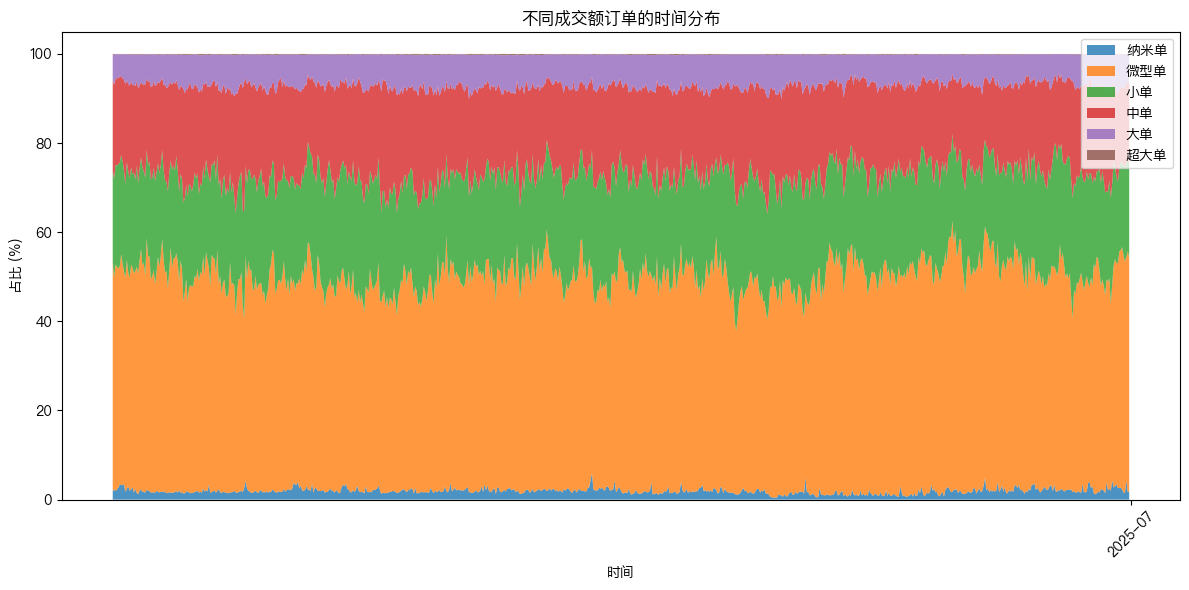

In [5]:
# 超大单（单笔成交额大于10万美元）、大单（单笔成交额大于1万美元，小于10万美元）、中单（单笔成交额大于1000美元，小于1万美元）、小单（单笔成交额大于100美元，小于1000美元）、微型单（单笔成交额小于100美元，大于10美元）以及纳米单（单笔成交额小于10美元）。

trades_df.tail(100)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

# ---------- 配置中文字体 ----------
plt.rcParams['font.sans-serif'] = ['PingFang HK']  
plt.rcParams['axes.unicode_minus'] = False  # 解决负号“-”显示为方块的问题
# ---------------------------------

def classify_order(quote_qty):
    if quote_qty > 100_000:  # 10万美元
        return "超大单"
    elif quote_qty >= 10_000:  # 1万 ~ 10万美元
        return "大单"
    elif quote_qty >= 1_000:  # 1000美元 ~ 1万美元
        return "中单"
    elif quote_qty >= 100:  # 100 ~ 1000美元
        return "小单"
    elif quote_qty >= 10:  # 10 ~ 100美元
        return "微型单"
    else:  # < 10美元
        return "纳米单"

trade_df_copy = trades_df.copy()
# 新增订单类型列
trade_df_copy['order_type'] = trade_df_copy['quote_qty'].apply(classify_order)

# 按天分组，统计各类型订单数量（缺失类型填0）
daily_counts = trade_df_copy.groupby(
    [pd.Grouper(key='time', freq='H'), 'order_type']
).size().unstack(fill_value=0)

# 计算每日各类型占比（转成百分比）
daily_pct = daily_counts.div(daily_counts.sum(axis=1), axis=0) * 100

# 定义堆叠顺序（从下到上，与示例图层次一致）
categories = ["纳米单", "微型单", "小单", "中单", "大单", "超大单"]

# 创建画布
plt.figure(figsize=(12, 6))

# 绘制堆叠面积图
plt.stackplot(
    daily_pct.index,  # X轴：时间
    [daily_pct.get(cat, pd.Series(0, index=daily_pct.index)) for cat in categories],
    labels=categories,
    alpha=0.8  # 透明度
)

# 格式化X轴日期（如“年-月”，每3个月标一次）
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)  # 日期标签旋转，避免重叠

# 添加标签与标题
plt.xlabel("时间")
plt.ylabel("占比 (%)")
plt.title("不同成交额订单的时间分布")
plt.legend(loc="upper right")  # 图例位置
plt.tight_layout()  # 自动调整布局
plt.show()


In [ ]:
# import matplotlib.font_manager as fm
# chinese_fonts = [f.name for f in fm.fontManager.ttflist if 'pingfang' in f.name.lower()]
# print("Mac 系统中含“PingFang”的字体：", chinese_fonts)

Mac 系统中含“PingFang”的字体： ['PingFang HK']


In [6]:
conditions = [
     trades_df['quote_qty'] > 100000,                      # 超大单：大于10万美元
    (trades_df['quote_qty'] > 10000) & (trades_df['quote_qty'] <= 100000),  # 大单：1万-10万美元
    (trades_df['quote_qty'] > 1000) & (trades_df['quote_qty'] <= 10000),    # 中单：1000-1万美元
    (trades_df['quote_qty'] > 100) & (trades_df['quote_qty'] <= 1000),      # 小单：100-1000美元
    (trades_df['quote_qty'] > 10) & (trades_df['quote_qty'] <= 100),        # 微型单：10-100美元
    trades_df['quote_qty'] <= 10                                 # 纳米单：小于等于10美元
]

order_types = ['super', 'big', 'medium', 'small', 'micro', 'nano']
trades_df['order_type'] = np.select(conditions, order_types, default='unknown')


unique_values, counts = np.unique(trades_df['order_type'], return_counts=True)

value_counts = dict(zip(unique_values, counts))
print("数组中的唯一值：", unique_values)
print("每个值的出现次数：", counts)
print("值-次数对应关系：", value_counts)


数组中的唯一值： ['big' 'medium' 'micro' 'nano' 'small' 'super']
每个值的出现次数： [10873882 30163310 71646176  2634745 32200824   256349]
值-次数对应关系： {'big': 10873882, 'medium': 30163310, 'micro': 71646176, 'nano': 2634745, 'small': 32200824, 'super': 256349}


<Axes: >

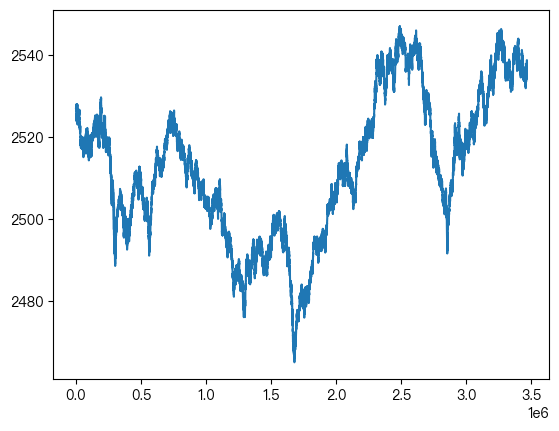

In [42]:
trades_df.price.plot()

In [7]:
def make_interval_feature_dataset(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',  # 'past' 使用过去N个bar的[start,end)，'future' 使用未来N个bar（注意可能泄露）
    add_lags: int = 0,
    rolling_windows: Optional[List[int]] = None,
    rolling_stats: Optional[List[str]] = None,
    bar_zip_path :str = None
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    标签：由 dollar bars 生成的未来 N-bar 对数收益。
    因子：对齐到对应区间 [start_time, end_time)（过去或未来N个bar）上基于逐笔成交直接计算。
    返回：X_interval, y, bars
    """

    bars = None
    if bar_zip_path is not None and os.path.exists(bar_zip_path):
        bars = pd.read_csv(bar_zip_path)
    else:
        bars = build_dollar_bars(trades, dollar_threshold=dollar_threshold)
        os.makedirs(os.path.dirname(bar_zip_path), exist_ok=True)
        bars.to_csv(bar_zip_path, index=False,compression={'method': 'zip', 'archive_name': 'bars.csv'})


    if bars.empty:
        return pd.DataFrame(), pd.Series(dtype=float), bars

    bars = bars.reset_index(drop=True)
    bars['bar_id'] = bars.index
    bars['start_time'] = pd.to_datetime(bars['start_time'])
    bars['end_time'] = pd.to_datetime(bars['end_time'])
    close_s = bars.set_index('bar_id')['close']

    # 未来 N-bar 对数收益
    end_time_s = bars.set_index('bar_id')['end_time']
    y = pd.DataFrame(index=close_s.index)

    for horizon in horizon_bars: 
        y_series_log_return = np.log(close_s.shift(-horizon) / close_s)
        tH_time = end_time_s.shift(-horizon)
        y[f'log_return_{horizon}'] = y_series_log_return
        y[f't0_time_{horizon}'] = end_time_s  # 起始时间（同一时间点对不同持有期相同）
        y[f'tH_time_{horizon}'] = tH_time
        
    
    # 预构建高性能上下文（一次即可）
    ctx = _build_trades_context(trades, bars)

    # 计算每个样本的区间
    features = []
    idx = 1
    record = []
    for bar_id in close_s.index:
        if window_mode == 'past':
            bar_window_start_idx = bar_id - feature_window_bars
            if bar_window_start_idx < 0:
                features.append({'bar_id': bar_id, '_skip': True})
                continue
            bar_window_end_idx = bar_id - 1
            record.append({
                'bar_id': bar_id,
                'bar_window_start_idx': bar_window_start_idx,
                'bar_window_end_idx': bar_window_end_idx,
                'horizon_bar_idx': bar_id + horizon_bars[-1]
            })

            feature_start_ts = bars.loc[bar_window_start_idx, 'start_time']
            feature_end_ts = bars.loc[bar_window_end_idx, 'end_time']
            feat = _compute_interval_trade_features_fast(ctx=ctx, start_ts=feature_start_ts, end_ts=feature_end_ts, bars=bars, bar_window_start_idx=bar_window_start_idx, bar_window_end_idx=bar_window_end_idx)
            if idx % 50 == 0:
                print(f'idx={idx}, total={len(close_s.index)}')
            idx = idx + 1
            feat['bar_id'] = bar_id
            feat['feature_start'] = feature_start_ts  # 特征计算区间的开始
            feat['feature_end'] = feature_end_ts      # 特征计算区间的结束
            feat['prediction_time'] = bars.loc[bar_id, 'end_time']  # 预测时间点
            for horizon in horizon_bars:
                if bar_id + horizon < len(bars) :
                    feat[f'settle_time_{horizon}'] = bars.loc[bar_id + horizon, 'end_time']
                else:
                    feat[f'settle_time_{horizon}'] = np.nan
            features.append(feat)

    X = pd.DataFrame(features).set_index('bar_id')
    if '_skip' in X.columns:
        keep_idx = X['_skip'] != True
        X = X.loc[keep_idx].drop(columns=['_skip'])
    
    # 对齐标签
    y = y.loc[X.index]

    # 可选：对区间因子再做滞后/滚动（通常不需要，默认不加）
    if add_lags or rolling_windows:
        X = _add_bar_lags_and_rollings(
            X,
            add_lags=add_lags,
            rolling_windows=rolling_windows,
            rolling_stats=rolling_stats,
        ).dropna()
        y = y.loc[X.index]

    return X, y, bars

def run_bar_interval_pipeline_v2(
    trades: pd.DataFrame,
    dollar_threshold: float,
    feature_window_bars: int = 10,
    horizon_bars: Optional[List[int]] = [5],
    window_mode: str = 'past',
    n_splits: int = 5,
    embargo_bars: Optional[int] = None,
    model_type: str = 'ridge',
    random_state: int = 42,
    bar_zip_path = bar_zip_path
):
    """
    按 N 个 dollar bar 定义的时间区间计算因子，标签为未来 N-bar 对数收益；
    使用区间的真实 end_time 作为索引做 Purged K-Fold，embargo 由 bar 中位时长换算。
    """
    X, y, bars = make_interval_feature_dataset(
        trades=trades,
        dollar_threshold=dollar_threshold,
        feature_window_bars=feature_window_bars,
        horizon_bars=horizon_bars,
        window_mode=window_mode,
        bar_zip_path = bar_zip_path
    )
    
    mask = y[f'log_return_{horizon_bars[-1]}'].notna() & np.isfinite(y[f'log_return_{horizon_bars[-1]}'].values)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan)
    y = y.loc[X.index]
    # bars = bars[bars['end_time'].isin(X['feature_end'])]

    if X.empty or y.empty:
        print('数据不足或阈值设置过大，无法构造区间数据集 X {} y {} bar{}'.format(len(X), len(y), len(bars)))

    X2 = X.copy()
    y2 = y.copy()
 
    return X2, y2, bars

horizon_bars = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [8]:
# bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'

X2, y2, bars = run_bar_interval_pipeline_v2(
    trades=trades_df,
    dollar_threshold=10000 * 6000,
    feature_window_bars=30,
    horizon_bars = horizon_bars,
    window_mode='past',
    n_splits=5,
    embargo_bars=None,
    model_type='ridge',
    bar_zip_path=bar_zip_path
)

# print(res.get('eval', {}).get('summary'))

: 

In [46]:
bars

,start_time,end_time,open,high,low,close,volume,dollar_value,buy_volume,sell_volume,trades,start_trade_idx,end_trade_idx,bar_id
0,2025-06-01 00:00:04.779,2025-06-01 00:12:14.256,2527.08,2527.98,2522.22,2522.22,23773.670,6.002827e+07,11291.717,12481.953,28970,0,28970,0
1,2025-06-01 00:12:14.263,2025-06-01 00:13:22.123,2522.22,2522.82,2517.28,2520.00,23803.801,5.997961e+07,9736.867,14066.934,12987,28970,41957,1
2,2025-06-01 00:13:22.123,2025-06-01 00:17:03.625,2520.00,2520.00,2515.06,2518.04,23827.783,5.999997e+07,8491.698,15336.085,22117,41957,64074,2
3,2025-06-01 00:17:03.625,2025-06-01 00:24:10.931,2518.04,2521.94,2515.80,2518.32,23819.939,5.999236e+07,13123.518,10696.421,21223,64074,85297,3
4,2025-06-01 00:24:11.471,2025-06-01 00:34:00.712,2518.32,2522.20,2514.28,2516.80,23834.447,5.999982e+07,11625.853,12208.594,32037,85297,117334,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2025-06-01 22:44:19.660,2025-06-01 22:56:18.879,2537.21,2537.47,2531.00,2532.46,23678.908,6.000273e+07,11941.020,11737.888,18947,3332745,3351692,140
141,2025-06-01 22:56:18.879,2025-06-01 23:08:51.615,2532.46,2541.79,2531.40,2541.44,23642.695,6.000172e+07,13440.629,10202.066,21420,3351692,3373112,141
142,2025-06-01 23:08:51.615,2025-06-01 23:19:09.970,2541.44,2542.21,2536.09,2541.98,23634.340,6.003203e+07,10754.635,12879.705,22032,3373112,3395144,142
143,2025-06-01 23:19:09.970,2025-06-01 23:33:34.242,2541.99,2544.00,2534.51,2537.20,23634.001,5.999630e+07,11871.518,11762.483,28454,3395144,3423598,143


In [47]:
X2.tail(100)
print(X2.columns)

Index(['rv', 'bpv', 'jump_rv_bpv', 'micro_dp_short', 'micro_dp_zscore',
       'mr_rho1', 'mr_strength', 'hl_amplitude_ratio', 'signed_vwap_deviation',
       'vwap_deviation', 'kyle_lambda', 'amihud_lambda', 'hasbrouck_lambda',
       'impact_half_life', 'impact_perm_share', 'impact_transient_share',
       'corr_cumsum_signed_qty_logp', 'corr_cumsum_signed_dollar_logp',
       'runlen_buy_max', 'runlen_sell_max', 'runlen_buy_mean',
       'runlen_sell_mean', 'alt_frequency', 'p_pos_to_pos', 'p_neg_to_neg',
       'hf_flip_rate', 'large_q90_buy_dollar_sum', 'large_q90_sell_dollar_sum',
       'large_q90_buy_count', 'large_q90_sell_count', 'large_q90_dollar_share',
       'large_q90_lti', 'large_q90_signed_dollar_ps',
       'large_q95_buy_dollar_sum', 'large_q95_sell_dollar_sum',
       'large_q95_buy_count', 'large_q95_sell_count', 'large_q95_dollar_share',
       'large_q95_lti', 'large_q95_signed_dollar_ps', 'large_buy_dollar_sum',
       'large_sell_dollar_sum', 'large_buy_count',

In [48]:
y2

,log_return_1,t0_time_1,tH_time_1,log_return_2,t0_time_2,tH_time_2,log_return_3,t0_time_3,tH_time_3,log_return_4,...,tH_time_15,log_return_16,t0_time_16,tH_time_16,log_return_17,t0_time_17,tH_time_17,log_return_18,t0_time_18,tH_time_18
bar_id,,,,,,,,,,,,,,,,,,,,,
30,-0.002543,2025-06-01 06:03:58.609,2025-06-01 06:21:52.622,-0.002144,2025-06-01 06:03:58.609,2025-06-01 06:47:45.803,-0.002861,2025-06-01 06:03:58.609,2025-06-01 07:11:23.292,-0.003750,...,2025-06-01 09:33:39.068,-0.012814,2025-06-01 06:03:58.609,2025-06-01 09:41:07.404,-0.015285,2025-06-01 06:03:58.609,2025-06-01 09:46:34.527,-0.013761,2025-06-01 06:03:58.609,2025-06-01 09:47:27.435
31,0.000398,2025-06-01 06:21:52.622,2025-06-01 06:47:45.803,-0.000319,2025-06-01 06:21:52.622,2025-06-01 07:11:23.292,-0.001208,2025-06-01 06:21:52.622,2025-06-01 07:37:18.117,-0.000873,...,2025-06-01 09:41:07.404,-0.012742,2025-06-01 06:21:52.622,2025-06-01 09:46:34.527,-0.011218,2025-06-01 06:21:52.622,2025-06-01 09:47:27.435,-0.008595,2025-06-01 06:21:52.622,2025-06-01 09:50:20.904
32,-0.000717,2025-06-01 06:47:45.803,2025-06-01 07:11:23.292,-0.001606,2025-06-01 06:47:45.803,2025-06-01 07:37:18.117,-0.001271,2025-06-01 06:47:45.803,2025-06-01 08:00:36.903,-0.003339,...,2025-06-01 09:46:34.527,-0.011616,2025-06-01 06:47:45.803,2025-06-01 09:47:27.435,-0.008993,2025-06-01 06:47:45.803,2025-06-01 09:50:20.904,-0.007716,2025-06-01 06:47:45.803,2025-06-01 09:59:56.162
33,-0.000889,2025-06-01 07:11:23.292,2025-06-01 07:37:18.117,-0.000554,2025-06-01 07:11:23.292,2025-06-01 08:00:36.903,-0.002622,2025-06-01 07:11:23.292,2025-06-01 08:13:40.235,-0.004438,...,2025-06-01 09:47:27.435,-0.008276,2025-06-01 07:11:23.292,2025-06-01 09:50:20.904,-0.006999,2025-06-01 07:11:23.292,2025-06-01 09:59:56.162,-0.008541,2025-06-01 07:11:23.292,2025-06-01 10:06:49.000
34,0.000335,2025-06-01 07:37:18.117,2025-06-01 08:00:36.903,-0.001733,2025-06-01 07:37:18.117,2025-06-01 08:13:40.235,-0.003548,2025-06-01 07:37:18.117,2025-06-01 08:26:02.223,-0.000738,...,2025-06-01 09:50:20.904,-0.006110,2025-06-01 07:37:18.117,2025-06-01 09:59:56.162,-0.007652,2025-06-01 07:37:18.117,2025-06-01 10:06:49.000,-0.005773,2025-06-01 07:37:18.117,2025-06-01 10:18:12.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,-0.002973,2025-06-01 19:02:29.880,2025-06-01 19:04:25.744,-0.004126,2025-06-01 19:02:29.880,2025-06-01 19:13:37.797,-0.001666,2025-06-01 19:02:29.880,2025-06-01 19:33:00.711,-0.000591,...,2025-06-01 22:27:02.157,0.004965,2025-06-01 19:02:29.880,2025-06-01 22:31:21.165,0.005422,2025-06-01 19:02:29.880,2025-06-01 22:44:19.660,0.003548,2025-06-01 19:02:29.880,2025-06-01 22:56:18.879
123,-0.001153,2025-06-01 19:04:25.744,2025-06-01 19:13:37.797,0.001307,2025-06-01 19:04:25.744,2025-06-01 19:33:00.711,0.002382,2025-06-01 19:04:25.744,2025-06-01 19:47:17.754,0.003072,...,2025-06-01 22:31:21.165,0.008395,2025-06-01 19:04:25.744,2025-06-01 22:44:19.660,0.006521,2025-06-01 19:04:25.744,2025-06-01 22:56:18.879,0.010061,2025-06-01 19:04:25.744,2025-06-01 23:08:51.615
124,0.002460,2025-06-01 19:13:37.797,2025-06-01 19:33:00.711,0.003535,2025-06-01 19:13:37.797,2025-06-01 19:47:17.754,0.004225,2025-06-01 19:13:37.797,2025-06-01 20:04:34.480,0.004882,...,2025-06-01 22:44:19.660,0.007674,2025-06-01 19:13:37.797,2025-06-01 22:56:18.879,0.011214,2025-06-01 19:13:37.797,2025-06-01 23:08:51.615,0.011426,2025-06-01 19:13:37.797,2025-06-01 23:19:09.970


In [49]:
X2_y_pd = pd.concat([X2, y2], axis=1)

def winsorize_single_factor(series, quantiles=(0.01, 0.99)):
    if len(quantiles) != 2 or quantiles[0] >= quantiles[1]:
        raise ValueError("quantiles必须是(低分位, 高分位)，且低分位 < 高分位")
    
    if quantiles[0] < 0 or quantiles[1] > 1:
        raise ValueError("分位数必须在[0, 1]范围内")
    
    # 定义单组缩尾函数
    lower = series.quantile(quantiles[0])
    upper = series.quantile(quantiles[1])
    return  series.clip(lower=lower, upper=upper)

def rolling_z_score(series, rolling_window=30):
    mean_ = ta.MA(series,rolling_window)
    std_ = ta.STDDEV(series,rolling_window)
    return (series - mean_) / std_

def _robust_zscore(series: pd.Series, rolling_window = 30) -> pd.Series:
    """基于中位数与MAD的稳健z分数（避免极端值影响）。"""
    x = pd.to_numeric(series, errors='coerce')
    eps = 1e-9

    w = int(rolling_window)
    med_roll = x.rolling(window=w).median()
    mad_roll = (x - med_roll).abs().rolling(window=w).median()
    return 0.6745 * (x - med_roll) / (mad_roll + eps)

X2_y_pd


,rv,bpv,jump_rv_bpv,micro_dp_short,micro_dp_zscore,mr_rho1,mr_strength,hl_amplitude_ratio,signed_vwap_deviation,vwap_deviation,...,tH_time_15,log_return_16,t0_time_16,tH_time_16,log_return_17,t0_time_17,tH_time_17,log_return_18,t0_time_18,tH_time_18
bar_id,,,,,,,,,,,,,,,,,,,,,
30,0.006292,0.003102,0.003190,-0.000016,-0.722316,-0.479936,0.479936,0.016400,-0.002668,0.002668,...,2025-06-01 09:33:39.068,-0.012814,2025-06-01 06:03:58.609,2025-06-01 09:41:07.404,-0.015285,2025-06-01 06:03:58.609,2025-06-01 09:46:34.527,-0.013761,2025-06-01 06:03:58.609,2025-06-01 09:47:27.435
31,0.006291,0.003102,0.003189,-0.000004,0.155754,-0.479972,0.479972,0.016400,-0.001903,0.001903,...,2025-06-01 09:41:07.404,-0.012742,2025-06-01 06:21:52.622,2025-06-01 09:46:34.527,-0.011218,2025-06-01 06:21:52.622,2025-06-01 09:47:27.435,-0.008595,2025-06-01 06:21:52.622,2025-06-01 09:50:20.904
32,0.006249,0.003083,0.003166,0.000000,1.000000,-0.480295,0.480295,0.016400,0.000561,-0.000561,...,2025-06-01 09:46:34.527,-0.011616,2025-06-01 06:47:45.803,2025-06-01 09:47:27.435,-0.008993,2025-06-01 06:47:45.803,2025-06-01 09:50:20.904,-0.007716,2025-06-01 06:47:45.803,2025-06-01 09:59:56.162
33,0.006247,0.003082,0.003166,0.000000,0.420084,-0.480219,0.480219,0.016400,0.000100,-0.000100,...,2025-06-01 09:47:27.435,-0.008276,2025-06-01 07:11:23.292,2025-06-01 09:50:20.904,-0.006999,2025-06-01 07:11:23.292,2025-06-01 09:59:56.162,-0.008541,2025-06-01 07:11:23.292,2025-06-01 10:06:49.000
34,0.006245,0.003081,0.003164,0.000000,-0.788892,-0.480271,0.480271,0.016400,0.000698,-0.000698,...,2025-06-01 09:50:20.904,-0.006110,2025-06-01 07:37:18.117,2025-06-01 09:59:56.162,-0.007652,2025-06-01 07:37:18.117,2025-06-01 10:06:49.000,-0.005773,2025-06-01 07:37:18.117,2025-06-01 10:18:12.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,0.000919,0.000389,0.000530,-0.000111,-1.068623,-0.366762,0.366762,0.022006,0.003984,-0.003984,...,2025-06-01 22:27:02.157,0.004965,2025-06-01 19:02:29.880,2025-06-01 22:31:21.165,0.005422,2025-06-01 19:02:29.880,2025-06-01 22:44:19.660,0.003548,2025-06-01 19:02:29.880,2025-06-01 22:56:18.879
123,0.000731,0.000300,0.000431,0.000044,2.406519,-0.344696,0.344696,0.022006,0.001498,-0.001498,...,2025-06-01 22:31:21.165,0.008395,2025-06-01 19:04:25.744,2025-06-01 22:44:19.660,0.006521,2025-06-01 19:04:25.744,2025-06-01 22:56:18.879,0.010061,2025-06-01 19:04:25.744,2025-06-01 23:08:51.615
124,0.000716,0.000291,0.000425,0.000000,-1.000000,-0.340681,0.340681,0.022006,0.004273,-0.004273,...,2025-06-01 22:44:19.660,0.007674,2025-06-01 19:13:37.797,2025-06-01 22:56:18.879,0.011214,2025-06-01 19:13:37.797,2025-06-01 23:08:51.615,0.011426,2025-06-01 19:13:37.797,2025-06-01 23:19:09.970


In [50]:
print(X2.columns)

Index(['rv', 'bpv', 'jump_rv_bpv', 'micro_dp_short', 'micro_dp_zscore',
       'mr_rho1', 'mr_strength', 'hl_amplitude_ratio', 'signed_vwap_deviation',
       'vwap_deviation', 'kyle_lambda', 'amihud_lambda', 'hasbrouck_lambda',
       'impact_half_life', 'impact_perm_share', 'impact_transient_share',
       'corr_cumsum_signed_qty_logp', 'corr_cumsum_signed_dollar_logp',
       'runlen_buy_max', 'runlen_sell_max', 'runlen_buy_mean',
       'runlen_sell_mean', 'alt_frequency', 'p_pos_to_pos', 'p_neg_to_neg',
       'hf_flip_rate', 'large_q90_buy_dollar_sum', 'large_q90_sell_dollar_sum',
       'large_q90_buy_count', 'large_q90_sell_count', 'large_q90_dollar_share',
       'large_q90_lti', 'large_q90_signed_dollar_ps',
       'large_q95_buy_dollar_sum', 'large_q95_sell_dollar_sum',
       'large_q95_buy_count', 'large_q95_sell_count', 'large_q95_dollar_share',
       'large_q95_lti', 'large_q95_signed_dollar_ps', 'large_buy_dollar_sum',
       'large_sell_dollar_sum', 'large_buy_count',

bar_id
30          NaN
31          NaN
32          NaN
33          NaN
34          NaN
         ...   
122   -0.663536
123   -0.723809
124   -0.591039
125   -0.593435
126   -0.422070
Name: large_q95_lti, Length: 97, dtype: float64
[0.09964189894494564, 0.11073462981370362, 0.09308954420913694, 0.06512886247332043, 0.017015083394063442, -0.040532658311799766, -0.11710958381526355, -0.18572431847821452, -0.26734313848340563, -0.3306196385273063, -0.38231161026252114, -0.44766446944031074, -0.5158788321597816, -0.5773593821412304, -0.6272903927426596, -0.6703546625376305, -0.7024565540436689, -0.7436386037555951]


<Axes: >

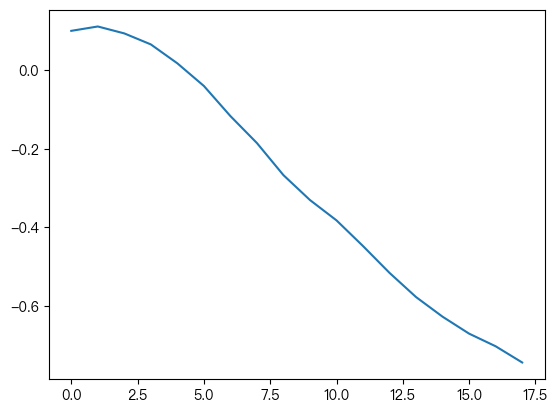

In [52]:
factor_name = 'large_q95_lti'

def build_factor_corr(factor_name):
    winsorize_value = winsorize_single_factor(X2_y_pd[f'{factor_name}'])
    factor_robust_zscore = _robust_zscore(winsorize_value, rolling_window=30)

    corr_list = []
    for horizon in horizon_bars:
        corr_list.append(factor_robust_zscore.corr(X2_y_pd[f'log_return_{horizon}']))
    return factor_robust_zscore, corr_list

factor_robust_zscore, corr_list = build_factor_corr(factor_name)

print(factor_robust_zscore)
print(corr_list)
pd.Series(corr_list).plot()

# factor_robust_zscore.hist(bins=100)

# factor_robust_zscore[factor_robust_zscore==0].count()

# factor_robust_zscore.dropna(inplace=True)
# unique_values, counts = np.unique(factor_robust_zscore, return_counts=True)
# value_counts = dict(zip(unique_values, counts))
# print("数组中的唯一值：", unique_values)
# print("每个值的出现次数：", counts)
# print("值-次数对应关系：", value_counts)

# factor_robust_zscore.describe()
# pd.Series(corr_list).plot()



# log_return_corr = pd.concat(corr_list)

# print(log_return_corr) 

# log_return_corr.plot()

In [15]:
X2_y_pd

,ofi_signed_qty_sum,ofi_signed_quote_sum,gof_by_count,gof_by_volume,rv,bpv,jump_rv_bpv,micro_dp_short,micro_dp_zscore,mr_rho1,...,tH_time_15,log_return_16,t0_time_16,tH_time_16,log_return_17,t0_time_17,tH_time_17,log_return_18,t0_time_18,tH_time_18
bar_id,,,,,,,,,,,,,,,,,,,,,
30,-34740.942,-8.679000e+07,0.021983,-0.048480,0.006292,0.003102,0.003190,-0.000012,-0.229413,-0.479936,...,2025-06-01 09:33:39.068,-0.012814,2025-06-01 06:03:58.609,2025-06-01 09:41:07.404,-0.015285,2025-06-01 06:03:58.609,2025-06-01 09:46:34.527,-0.013761,2025-06-01 06:03:58.609,2025-06-01 09:47:27.435
31,-35381.308,-8.838797e+07,0.021224,-0.049370,0.006291,0.003102,0.003189,-0.000004,0.100505,-0.479972,...,2025-06-01 09:41:07.404,-0.012742,2025-06-01 06:21:52.622,2025-06-01 09:46:34.527,-0.011218,2025-06-01 06:21:52.622,2025-06-01 09:47:27.435,-0.008595,2025-06-01 06:21:52.622,2025-06-01 09:50:20.904
32,-37788.748,-9.441067e+07,0.019157,-0.052723,0.006249,0.003083,0.003166,0.000000,1.000000,-0.480295,...,2025-06-01 09:46:34.527,-0.011616,2025-06-01 06:47:45.803,2025-06-01 09:47:27.435,-0.008993,2025-06-01 06:47:45.803,2025-06-01 09:50:20.904,-0.007716,2025-06-01 06:47:45.803,2025-06-01 09:59:56.162
33,-29163.256,-7.269777e+07,0.027744,-0.040686,0.006247,0.003082,0.003166,0.000000,0.420084,-0.480219,...,2025-06-01 09:47:27.435,-0.008276,2025-06-01 07:11:23.292,2025-06-01 09:50:20.904,-0.006999,2025-06-01 07:11:23.292,2025-06-01 09:59:56.162,-0.008541,2025-06-01 07:11:23.292,2025-06-01 10:06:49.000
34,-35083.455,-8.758394e+07,0.022581,-0.048940,0.006245,0.003081,0.003164,0.000000,-0.788892,-0.480271,...,2025-06-01 09:50:20.904,-0.006110,2025-06-01 07:37:18.117,2025-06-01 09:59:56.162,-0.007652,2025-06-01 07:37:18.117,2025-06-01 10:06:49.000,-0.005773,2025-06-01 07:37:18.117,2025-06-01 10:18:12.230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,-17679.371,-4.462392e+07,-0.028905,-0.024829,0.000919,0.000389,0.000530,-0.000111,-1.180756,-0.366762,...,2025-06-01 22:27:02.157,0.004965,2025-06-01 19:02:29.880,2025-06-01 22:31:21.165,0.005422,2025-06-01 19:02:29.880,2025-06-01 22:44:19.660,0.003548,2025-06-01 19:02:29.880,2025-06-01 22:56:18.879
123,-26493.361,-6.700785e+07,-0.033479,-0.037198,0.000731,0.000300,0.000431,0.000012,-0.775860,-0.344696,...,2025-06-01 22:31:21.165,0.008395,2025-06-01 19:04:25.744,2025-06-01 22:44:19.660,0.006521,2025-06-01 19:04:25.744,2025-06-01 22:56:18.879,0.010061,2025-06-01 19:04:25.744,2025-06-01 23:08:51.615
124,-30433.450,-7.693573e+07,-0.032786,-0.042720,0.000716,0.000291,0.000425,0.000000,-1.000000,-0.340681,...,2025-06-01 22:44:19.660,0.007674,2025-06-01 19:13:37.797,2025-06-01 22:56:18.879,0.011214,2025-06-01 19:13:37.797,2025-06-01 23:08:51.615,0.011426,2025-06-01 19:13:37.797,2025-06-01 23:19:09.970


In [23]:
factor_name = 'jump_rv_bpv'

def build_factor_corr(factor_name):
    winsorize_value = winsorize_single_factor(X2_y_pd[f'{factor_name}'])
    factor_robust_zscore = rolling_z_score(winsorize_value, rolling_window=30)

    corr_list = []
    for horizon in horizon_bars:
        corr_list.append(factor_robust_zscore.corr(X2_y_pd[f'log_return_{horizon}']))
    return factor_robust_zscore, corr_list

factor_robust_zscore, corr_list = build_factor_corr(factor_name)

print(corr_list)

pd.Series(corr_list).plot()

# factor_robust_zscore.hist(bins=100)

# log_return_corr = pd.concat(corr_list)

# print(log_return_corr) 

# log_return_corr.plot()

TypeError: rolling_z_score() got an unexpected keyword argument 'rolling_window'

In [ ]:
# gof_by_count_deal_norm_position = ((gof_by_count_deal_norm>0.5)|(gof_by_count_deal_norm<-0.5)) * gof_by_count_deal_norm

# net_value = 1+(gof_by_count_deal_norm_position*X2_y_pd['close'].fillna(0)).cumsum()

# net_value.plot()